## 라이브러리 

In [1]:
import dlib, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image
import tensorflow.keras 
from tensorflow.keras import backend as K

detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

In [2]:
def find_faces(img):
    dets = detector(img, 1)
    
    if len(dets) == 0:
        return np.empty(0), np.empty(0), np.empty(0)
    
    rects, shapes = [], []
    shapes_np = np.zeros((len(dets), 68, 2), dtype=np.int)
    for k, d in enumerate(dets):
        rect = ((d.left(), d.top()), (d.right(), d.bottom()))
        rects.append(rect)

        shape = sp(img, d)
        
        # convert dlib shape to numpy array
        for i in range(0, 68):
            shapes_np[k][i] = (shape.part(i).x, shape.part(i).y)

        shapes.append(shape)
        
    return rects, shapes, shapes_np

def encode_faces(img, shapes):
    face_descriptors = []
    for shape in shapes:
        face_descriptor = facerec.compute_face_descriptor(img, shape)
        face_descriptors.append(np.array(face_descriptor))

    return np.array(face_descriptors)

# Compute Saved Face Descriptions

In [3]:
# descs = np.load('user_img/descs.npy', allow_pickle=True)

In [4]:
img_paths = {
     '진호': 'user_img/jinho.jpg',
     '태호': 'user_img/taeho.jpg',
     '아이린': 'user_img/irene.jpg',
     '조이': 'user_img/joy.jpeg',
     '창모': 'user_img/changmo.jpg',
     '홍철': 'user_img/hongchul.jpg',
     '명수': 'user_img/myungsoo.jpg'
}

descs = []

for name, img_path in img_paths.items(): 
    img = cv2.imread(img_path)
    _, img_shapes, _ = find_faces(img)
    descs.append([name, encode_faces(img, img_shapes)[0]])
    
np.save('user_img/descs.npy', descs)
print(descs)

[['진호', array([-0.04879012,  0.04577763,  0.03239387, -0.0242387 , -0.12101063,
       -0.03958031, -0.04642991, -0.0782209 ,  0.1446045 , -0.14853513,
        0.16190682, -0.01750871, -0.24530628, -0.01821542,  0.02707416,
        0.2063002 , -0.09112681, -0.09663653, -0.09868137, -0.06170246,
        0.07560354,  0.05087691,  0.04629379,  0.02567894, -0.06667768,
       -0.33469573, -0.09571624, -0.03965577, -0.00574449, -0.04491044,
       -0.02842267,  0.05642884, -0.12025725, -0.00545373,  0.02447622,
        0.09617449, -0.0774378 , -0.12608214,  0.23582913,  0.02423807,
       -0.22056392, -0.06751925,  0.02439487,  0.1798308 ,  0.16153571,
        0.02707396,  0.07446997, -0.10675956,  0.08333939, -0.20156547,
        0.07205243,  0.11419026,  0.04900903,  0.07981058,  0.0549146 ,
       -0.16005018,  0.08029511,  0.11327244, -0.11105975, -0.02102361,
        0.09611258, -0.10793499, -0.06145283, -0.03613228,  0.27737901,
        0.0936831 , -0.10636771, -0.1604587 ,  0.0958350

# real time face recognition and mosaic

In [7]:
cam = cv2.VideoCapture(0) # 노트북 웹캠 사용
cam.set(3, 640) # 너비
cam.set(4, 480) # 높이
font = cv2.FONT_HERSHEY_SIMPLEX # 폰트

while True:
    
    ret, img = cam.read() 
    img = cv2.flip(img, 1) # 좌우 대칭
#    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rects, shapes, _ = find_faces(img) # 얼굴 찾기
    descriptors = encode_faces(img, shapes) # 인코딩
    
    for i, desc in enumerate(descriptors):
        x = rects[i][0][0] # 얼굴 X 좌표
        y = rects[i][0][1] # 얼굴 Y 좌표
        w = rects[i][1][1]-rects[i][0][1] # 얼굴 너비 
        h = rects[i][1][0]-rects[i][0][0] # 얼굴 높이
        
        # 추출된 랜드마크와 데이터베이스의 랜드마크들 중 제일 짧은 거리를 찾는 부분
        descs1 = sorted(descs, key=lambda x: np.linalg.norm([desc] - x[1]))
        dist = np.linalg.norm([desc] - descs1[0][1], axis=1)
        
        if dist < 0.45: # 그 거리가 0.45보다 작다면 그 사람으로 판단 
            name = descs1[0][0]
        else:           # 0.45보다 크다면 모르는 사람으로 판단 -> 모자이크 처리
            name = "누구?"
            mosaic_img = cv2.resize(img[y:y+h, x:x+w], dsize=(0, 0), fx=0.04, fy=0.04) # 축소
            mosaic_img = cv2.resize(mosaic_img, (w, h), interpolation=cv2.INTER_AREA)  # 확대
            img[y:y+h, x:x+w] = mosaic_img # 인식된 얼굴 영역 모자이크 처리 

        cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2) # 얼굴 영역 박스 
        cv2.putText(img, str(dist)[1:6], (x+5,y+h-5), font, 2, (0,0,255), 4) # 사진에 거리 출력

#     영어
#     cv2.putText(img, name, (x+5,y-5), font, 2, (255,255,255), 4)

#     한글
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.text((x+5,y-50), name, font=ImageFont.truetype("./batang.ttc", 60), fill=(255,255,255))
    img = np.array(img)
        
    cv2.imshow('camera', img)
    
    k = cv2.waitKey(10) & 0xff # 'ESC' 키 누르면 종료
    if k == 27:
        break
        
cam.release()
cv2.destroyAllWindows()

# face recognition and mosaic

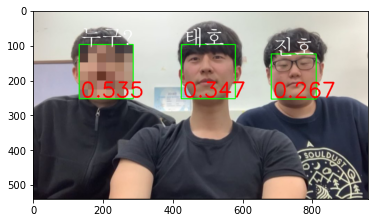

In [12]:
#img = cv2.imread('test_img/irene1.jpg')
img = cv2.imread('test_img/test.jpg')

rects, shapes, _ = find_faces(img) # 얼굴 찾기
descriptors = encode_faces(img, shapes) # 인코딩

for i, desc in enumerate(descriptors):
    x = rects[i][0][0] # 얼굴 X 좌표
    y = rects[i][0][1] # 얼굴 Y 좌표
    w = rects[i][1][1]-rects[i][0][1] # 얼굴 너비 
    h = rects[i][1][0]-rects[i][0][0] # 얼굴 높이        
        
    # 추출된 랜드마크와 데이터베이스의 랜드마크들 중 제일 짧은 거리를 찾는 부분
    descs1 = sorted(descs, key=lambda x: np.linalg.norm([desc] - x[1]))
    dist = np.linalg.norm([desc] - descs1[0][1], axis=1)

    if dist < 0.45: # 그 거리가 0.45보다 작다면 그 사람으로 판단 
        name = descs1[0][0]
    else:           # 0.45보다 크다면 모르는 사람으로 판단 -> 모자이크 처리
        name = "누구?"
        mosaic_img = cv2.resize(img[y:y+h, x:x+w], dsize=(0, 0), fx=0.04, fy=0.04) # 축소
        mosaic_img = cv2.resize(mosaic_img, (w, h), interpolation=cv2.INTER_AREA) # 확대
        img[y:y+h, x:x+w] = mosaic_img # 인식된 얼굴 영역 모자이크 처리
        
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2) # 얼굴 영역 박스 
    cv2.putText(img, str(dist)[1:6], (x+5,y+h-5), font, 2, (0,0,255), 4) # 사진에 거리 출력
    
#     영어
#     cv2.putText(img, name, (x+5,y-5), font, 2, (255,255,255), 4)

#     한글
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.text((x+5,y-50), name, font=ImageFont.truetype("./batang.ttc", 60), fill=(255,255,255))
    img = np.array(img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
plt.imshow(img)

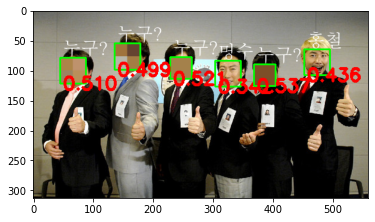

In [27]:
img = cv2.imread('test_img/inf.jpg')

rects, shapes, _ = find_faces(img) # 얼굴 찾기
descriptors = encode_faces(img, shapes) # 인코딩

for i, desc in enumerate(descriptors):
    x = rects[i][0][0] # 얼굴 X 좌표
    y = rects[i][0][1] # 얼굴 Y 좌표
    w = rects[i][1][1]-rects[i][0][1] # 얼굴 너비 
    h = rects[i][1][0]-rects[i][0][0] # 얼굴 높이        
        
    # 추출된 랜드마크와 데이터베이스의 랜드마크들 중 제일 짧은 거리를 찾는 부분
    descs1 = sorted(descs, key=lambda x: np.linalg.norm([desc] - x[1]))
    dist = np.linalg.norm([desc] - descs1[0][1], axis=1)

    if dist < 0.45: # 그 거리가 0.45보다 작다면 그 사람으로 판단 
        name = descs1[0][0]
    else:           # 0.45보다 크다면 모르는 사람으로 판단 -> 모자이크 처리
        name = "누구?"
        mosaic_img = cv2.resize(img[y:y+h, x:x+w], dsize=(0, 0), fx=0.04, fy=0.04) # 축소
        mosaic_img = cv2.resize(mosaic_img, (w, h), interpolation=cv2.INTER_AREA) # 확대
        img[y:y+h, x:x+w] = mosaic_img # 인식된 얼굴 영역 모자이크 처리
        
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2) # 얼굴 영역 박스 
    cv2.putText(img, str(dist)[1:6], (x+5,y+h+10), font, 1, (0,0,255), 4) # 사진에 거리 출력
    
#     영어
#     cv2.putText(img, name, (x+5,y-5), font, 2, (255,255,255), 4)

#     한글
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.text((x+5,y-30), name, font=ImageFont.truetype("./batang.ttc", 30), fill=(255,255,255))
    img = np.array(img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
plt.imshow(img)